# RvF - Starter Code Workbook

This is a workbook that you can upload to Google Colab to work on the project. It will download all the correct files and details to work on model development and improving.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip -q install grad-cam

# Change this to the folder containing your Kaggle API key (kaggle.json)
%env KAGGLE_KEY_FOLDER=MDST/RvF
!mkdir data
!export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/$KAGGLE_KEY_FOLDER && wget -O - "https://raw.githubusercontent.com/MichiganDataScienceTeam/W24-RvF/main/data/download.sh" | bash -s rvf10k

Streaming output truncated to the last 5000 lines.
  inflating: data/rvf10k/rvf10k/train/real/28056.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28081.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28160.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28181.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28190.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28192.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28194.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28197.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28199.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28247.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28281.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28308.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28316.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28332.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28342.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28345.jpg  
  inflating: data/rvf10k/rvf10k/train/real/28347.jpg  
  inflating: d

In [2]:
!rm -r W24-RvF starter_code
!git clone -q https://github.com/MichiganDataScienceTeam/W24-RvF.git
!mv W24-RvF/starter_code .
!rm -r W24-RvF

rm: cannot remove 'W24-RvF': No such file or directory
rm: cannot remove 'starter_code': No such file or directory


**KEY**: Make sure to save your work after every meeting! We recommend you do so via GitHub, but its not necessary.

The following sample code is the basics you need to get started with model development.

In [3]:
import torch
import torchvision.transforms.v2 as v2
import torch
from torch import nn, optim

In [4]:
if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  device = "cuda"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

CUDA available. Using GPU acceleration.


In [5]:
def preprocess(image) -> torch.Tensor:
    """
    Preprocesses an image by applying a series of transformation.

    Args:
        image (npt.ArrayLike): The input image to be preprocessed.

    Returns:
        torch.Tensor: The preprocessed image as a tensor.
    """

    tensor_converter = v2.Compose([ # Step 0: Convert from PIL Image to Torch Tensor (this is always necessary)
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True) # scale=True sets it back into [0,1]
    ])
    jitter = v2.ColorJitter(brightness=.5, hue=.3) # random color shift
    hflipper = v2.RandomHorizontalFlip(p=0.5) # 50% chance to horizontal flip
    vflipper = v2.RandomVerticalFlip(p=0.5) # 50% chance to vertical flip


    preprocessor = v2.Compose([
        tensor_converter,
        jitter,
        hflipper,
        vflipper,
    ])
    return preprocessor(image)

In [6]:
import torch
from torchvision import models, transforms, datasets
# from torchvision.models import resnet50, ResNet50_Weights

source_model = models.efficientnet_b5(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 134MB/s]


In [7]:
print(source_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [8]:
# VGG16
# source_model.classifier = torch.nn.Sequential(
#     # 512x49
#     torch.nn.Linear(25088, 1024), # 25088 x 1024
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.5),
#     torch.nn.Linear(1024, 128), # 1024 x 128
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.5),
#     torch.nn.Linear(128, 2) # 128 x 10
# )

# EfficientNetB0
source_model.classifier[1] = torch.nn.Linear(in_features=2048, out_features=2)

# EfficientNetV2
# source_model.classifier=torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=1280, out_features=2, bias=True),
# )

In [10]:
for parameter in source_model.features.parameters():
    parameter.requires_grad = True

In [9]:
print(source_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
source_model = source_model.to('cuda')

In [ ]:
# class Model(nn.Module):
#     # TODO: Define your CNN here!
#     def __init__(self):
#       """Constructor for the neural network."""
#       super(Model, self).__init__()        # Call superclass constructor
#       self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
#       self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
#       self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
#       self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
#       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#       self.relu = nn.ReLU()
#       self.flatten = nn.Flatten()
#       self.fc1 = nn.Linear(2048, 512)
#       self.fc2 = nn.Linear(512, 64)
#       self.fc3 = nn.Linear(64, 2)

#     def forward(self, x):
#         z1 = self.conv1(x)
#         h1 = self.relu(z1)
#         z2 = self.conv2(h1)
#         h2 = self.relu(z2)
#         p1 = self.pool(h2)

#         z3 = self.conv3(p1)
#         h3 = self.relu(z3)
#         z4 = self.conv4(h3)
#         h4 = self.relu(z4)
#         p2 = self.pool(h4)

#         flat = self.flatten(p2)
#         z = self.fc1(flat)
#         z = self.relu(z)
#         z = self.fc2(z)
#         z = self.relu(z)
#         z = self.fc3(z)

#         return z

Batch Accuracy: 0.96 , Total Accuracy: 0.78: 100%|██████████| 219/219 [03:50<00:00,  1.05s/it]


Epoch 1: Loss - (Train 99.64/Val 0.01), Accuracy - (Train 0.78/Val 0.86)


Batch Accuracy: 0.96 , Total Accuracy: 0.92: 100%|██████████| 219/219 [03:51<00:00,  1.06s/it]


Epoch 2: Loss - (Train 45.95/Val 0.01), Accuracy - (Train 0.92/Val 0.94)


Batch Accuracy: 0.92 , Total Accuracy: 0.95: 100%|██████████| 219/219 [03:50<00:00,  1.05s/it]


Epoch 3: Loss - (Train 26.40/Val 0.00), Accuracy - (Train 0.95/Val 0.95)


Batch Accuracy: 0.88 , Total Accuracy: 0.97: 100%|██████████| 219/219 [03:50<00:00,  1.05s/it]


Epoch 4: Loss - (Train 18.49/Val 0.00), Accuracy - (Train 0.97/Val 0.96)


Batch Accuracy: 0.96 , Total Accuracy: 0.98: 100%|██████████| 219/219 [03:50<00:00,  1.05s/it]


Epoch 5: Loss - (Train 13.82/Val 0.00), Accuracy - (Train 0.98/Val 0.97)


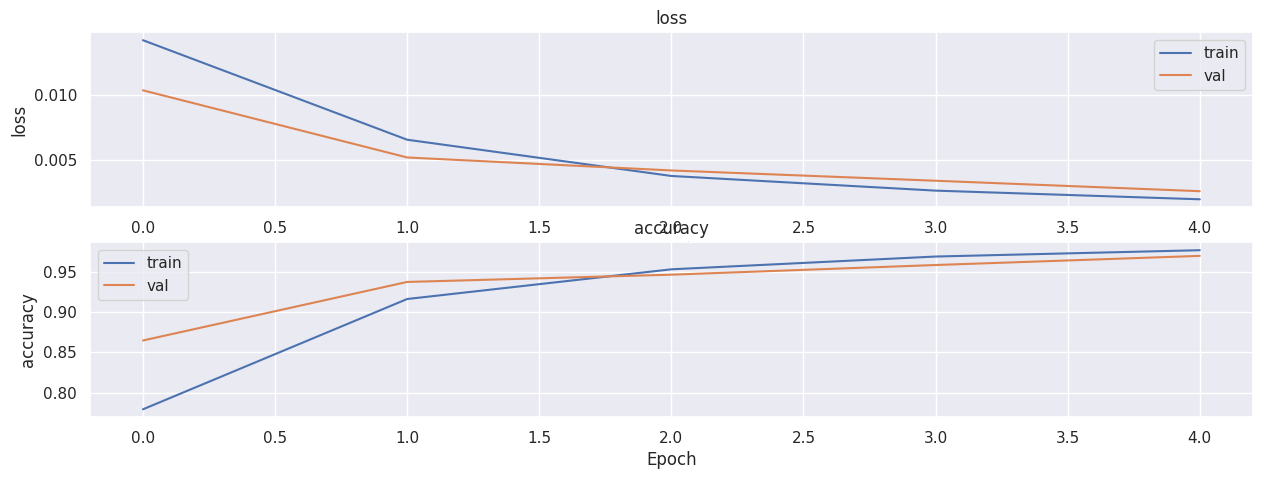

In [12]:
from starter_code.dataset import get_loaders
from starter_code.train import train_model, plot_performance, load_model

train_loader, val_loader = get_loaders(preprocessor=preprocess)

model = source_model # Model()
# lr=1e-3, weight_decay=3e-3 for not using pretrained weights
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # TODO: Change the optimizer to explore different options
criterion = torch.nn.CrossEntropyLoss() # TODO: Change the criterion to explore different options

history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)
plot_performance(history)

# Load the model from the training run
load_model(model, "checkpoints", 1) # change epoch from 0 to something else

In [101]:
from submission.dataset import get_loaders
from submission.train import train_model, plot_performance, load_model
from submission.model import Model
import torch
import os

# TODO: To test locally, change dataset from `data/rvk140k` to whichever dataset you use locally
train_loader, val_loader = get_loaders(preprocessor=preprocess, data_directory="data/rvf10k")

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = torch.nn.CrossEntropyLoss()

checkpoint_dir = f"checkpoints_{os.getenv('SLURM_JOB_ID')}"
history = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs=5,
    checkpoint_dir=checkpoint_dir,
)
plot_performance(history)

ModuleNotFoundError: No module named 'submission'

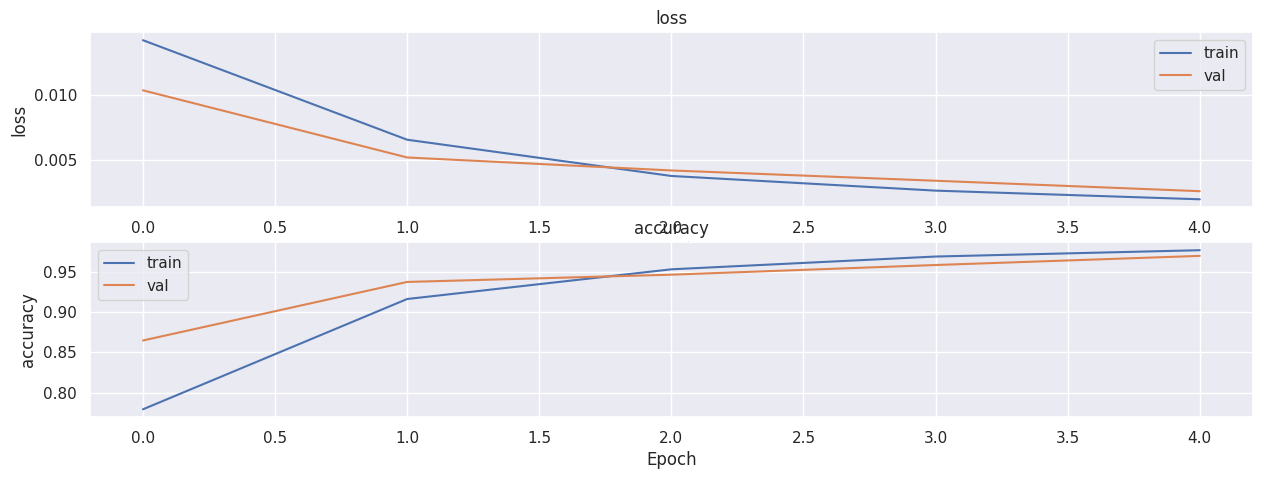

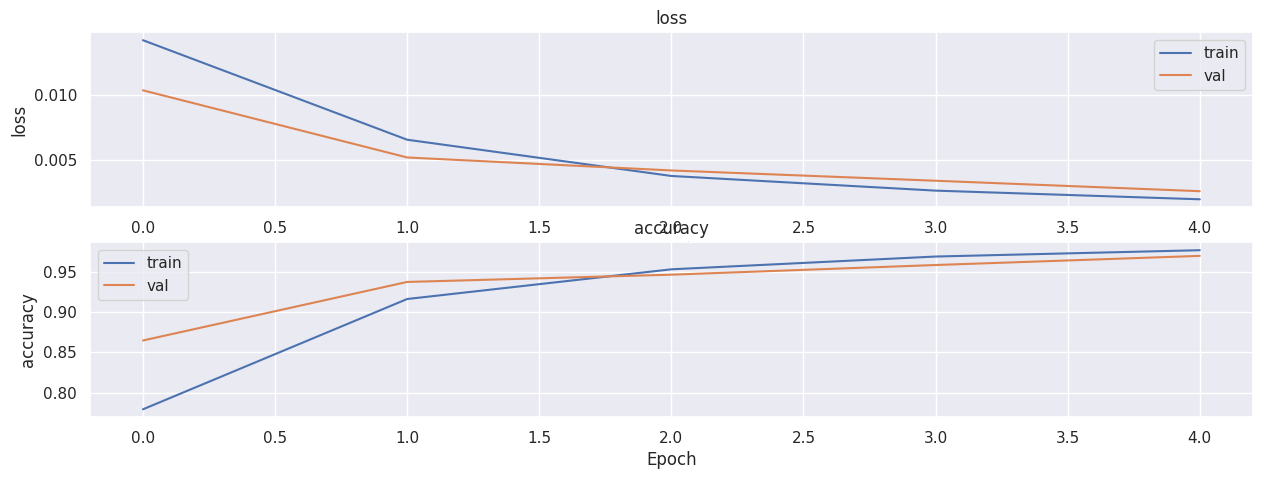

In [13]:
plot_performance(history)

**KEY**: At the end of each work session, submit this workbook via slack! This will allow the project leads to train your model on the larger 140k dataset over the week!

In [14]:
print(type(model.features[0]))

<class 'torchvision.ops.misc.Conv2dNormActivation'>


In [15]:
print(source_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [36]:
print(type(model.features[8][0]))

<class 'torch.nn.modules.conv.Conv2d'>


In [17]:
# Unfreeze layer to make GradCAM work
for parameter in source_model.features.parameters():
    parameter.requires_grad = True

In [16]:
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as tf

visualizations = []
cam = GradCAM(model=model, target_layers=[model.features[8][0]])

# Set Class 0 = figure out what parts of the image make the model think face is fake
targets = [ClassifierOutputTarget(0)]

for image_path in tqdm(Path("./data/rvf10k/train/fake").iterdir()):
    image = cv2.imread(str(image_path))
    pipeline = tf.Compose([
        tf.ToTensor(),
        tf.ConvertImageDtype(torch.float32),
    ])
    image = np.float32(image) / 255
    input_tensor = pipeline(image).view(1,3,256,256)

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    visualization = show_cam_on_image(image, grayscale_cam[0, :], use_rgb=True)
    visualizations.append(visualization)
    if len(visualizations) == 100:
        break

99it [00:15,  6.36it/s]


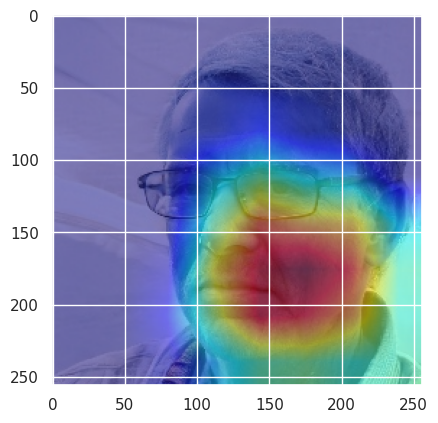

In [17]:
import matplotlib.pyplot as plt

plt.imshow(visualizations[0])

array([[[119, 120, 221],
        [120, 121, 222],
        [121, 122, 223],
        ...,
        [123, 202, 251],
        [123, 203, 252],
        [123, 203, 252]],

       [[120, 121, 222],
        [120, 121, 222],
        [120, 121, 222],
        ...,
        [123, 202, 251],
        [123, 202, 251],
        [123, 202, 251]],

       [[121, 122, 223],
        [120, 121, 222],
        [119, 120, 222],
        ...,
        [123, 202, 251],
        [123, 202, 251],
        [122, 202, 251]],

       ...,

       [[ 93,  92, 156],
        [ 93,  92, 156],
        [ 89,  88, 152],
        ...,
        [ 95,  92, 195],
        [108, 104, 208],
        [110, 107, 210]],

       [[ 92,  91, 156],
        [ 88,  87, 151],
        [ 84,  83, 148],
        ...,
        [ 92,  90, 193],
        [106, 104, 207],
        [110, 108, 211]],

       [[ 88,  87, 152],
        [ 88,  87, 151],
        [ 87,  86, 151],
        ...,
        [ 88,  86, 189],
        [105, 102, 206],
        [111, 108, 212]]], dtype=uint8)
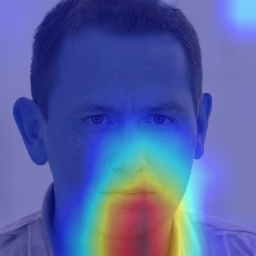

In [49]:
visualizations[1]

array([[[  9,  12,  82],
        [  5,   8,  78],
        [  2,   5,  75],
        ...,
        [  4,   8,  81],
        [  6,  10,  83],
        [  7,  11,  84]],

       [[  6,   9,  79],
        [  5,   8,  78],
        [  4,   7,  78],
        ...,
        [  6,  10,  82],
        [  6,  10,  83],
        [  6,  10,  82]],

       [[  3,   6,  77],
        [  4,   7,  77],
        [  3,   6,  77],
        ...,
        [  6,  10,  83],
        [  6,  10,  82],
        [  5,   9,  81]],

       ...,

       [[120, 122, 188],
        [120, 123, 188],
        [121, 123, 188],
        ...,
        [ 23, 142, 138],
        [ 23, 142, 138],
        [ 23, 142, 139]],

       [[119, 122, 188],
        [119, 122, 188],
        [121, 123, 188],
        ...,
        [ 23, 142, 137],
        [ 23, 142, 138],
        [ 23, 142, 139]],

       [[118, 122, 187],
        [118, 122, 187],
        [120, 123, 187],
        ...,
        [ 23, 142, 137],
        [ 23, 142, 138],
        [ 23, 142, 139]]], dtype=uint8)
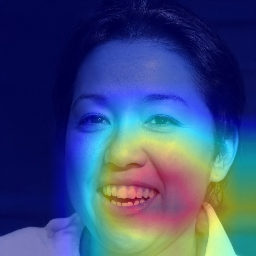

In [50]:
visualizations[60]

array([[[ 99, 101, 169],
        [100, 101, 170],
        [100, 102, 170],
        ...,
        [ 98, 100, 222],
        [ 98, 100, 222],
        [ 98, 100, 222]],

       [[100, 101, 170],
        [100, 102, 170],
        [100, 102, 170],
        ...,
        [ 99, 101, 223],
        [100, 101, 223],
        [100, 101, 223]],

       [[100, 102, 170],
        [100, 102, 170],
        [101, 102, 171],
        ...,
        [100, 101, 223],
        [100, 101, 223],
        [100, 101, 223]],

       ...,

       [[ 98, 100, 168],
        [ 98, 100, 168],
        [ 98, 100, 168],
        ...,
        [103, 155,  82],
        [102, 155,  81],
        [107, 161,  85]],

       [[ 98, 100, 168],
        [ 98, 100, 168],
        [ 98, 100, 168],
        ...,
        [101, 152,  79],
        [103, 156,  80],
        [110, 164,  88]],

       [[ 96,  98, 166],
        [ 97,  98, 167],
        [ 97,  98, 167],
        ...,
        [106, 157,  84],
        [ 98, 152,  76],
        [ 99, 152,  76]]], dtype=uint8)
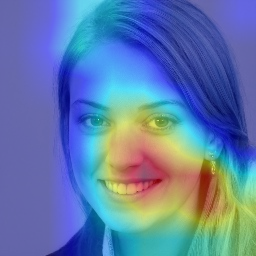

In [53]:
random = np.random.default_rng()
rint = random.integers(low=0, high=99, size=1)
visualizations[rint[0]]